In [1]:
# vou assumir q a secao ja existe
import os
from legacy.atributos import Atributos
secao = Atributos(os.path.join('data/existe/CL3822_maior.sgy'), resolucao = 25, deltaz = [9955, 2000])
secao.extent = [1, secao.X.shape[0] * secao.resolucao, 9955, 2000]

# Escolha de features

In [2]:
import ipywidgets as widgets
k_param = widgets.IntSlider(
    value=4,
    min=2,
    max=100,
    step=1,
    description='Clusters:',
    disabled=False,
    continuous_update=False,
    orientation='horizontal',
    readout=True,
    readout_format='d'
)
lista = widgets.SelectMultiple(
    options=[('Amplitude sísmica', 'X'), 
             ('Envelope', 'envelope'), ('Fase', 'fase'), ('Frequência', 'freq'), ('Sweetness', 'sweetness'), 
             ('RMS', 'rms'), ('TecVA', 'tecva'), 
             ('Semblance de alta resolução', 'semblance'), ('Sobel', 'sobel'), ('Marfurt', 'marfurt')],
    value=['X'],
    #rows=10,
    description='Atributos:',
    disabled=False
)

In [3]:
items = [lista, k_param]
processo = widgets.Box(children = items)
display(processo)

Box(children=(SelectMultiple(description='Atributos:', index=(0,), options=(('Amplitude sísmica', 'X'), ('Enve…

# Carregue outras features

In [4]:
import os
# from ipyfilechooser import FileChooser
# upload = FileChooser(os.getcwd() + '/data')
upload = widgets.FileUpload(accept='.sgy', multiple=True,)
display(upload)

FileUpload(value=(), accept='.sgy', description='Upload', multiple=True)

# Backend

In [7]:
import segyio
import numpy as np

from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans

from legacy.atributos import Atributos
from legacy.utils import plot, concatenate, subplot

In [8]:
from scipy.ndimage import zoom

def resample(obj, target):
    crop_vel(obj, target)
    zoom_factors = (
        obj.X.shape[0] / target.shape[0],
        obj.X.shape[1] / target.shape[1]
    )
    return zoom(target, zoom_factors, order=3)

def crop_vel(obj, target):
    extent = [2000, 9955]
    h = int(target.shape[1] * extent[0] / extent[1])
    target = target[:, h:]

In [9]:
new = []
for item in upload.value:
    print(item)
    new.append(segyio.tools.cube('data/' + item.name)[0, :, :])
    if new[-1].shape != secao.X.shape:
        new[-1] = resample(secao, new[-1])

{'name': 'CL3822_maior_PImp(full).sgy', 'type': '', 'size': 11309888, 'content': <memory at 0x716981e8e440>, 'last_modified': datetime.datetime(2024, 9, 16, 13, 7, 47, tzinfo=datetime.timezone.utc)}
{'name': 'CL3822_velocity.sgy', 'type': '', 'size': 3636464, 'content': <memory at 0x716981e8e380>, 'last_modified': datetime.datetime(2025, 5, 13, 13, 53, 22, tzinfo=datetime.timezone.utc)}


In [ ]:
secao._complexo()
secao._logaritmo()
secao._coherence()
secao._tecva()
secao._soterramento(marambaia = False)

In [11]:
k = k_param.value
obj = secao

scaler = StandardScaler()
Z = scaler.fit_transform(concatenate([getattr(secao, atr) for atr in lista.value] + new))
pca = PCA()
H = pca.fit_transform(Z)

kmeans = KMeans(n_clusters = k, n_init = 'auto', random_state = 0).fit(H)
clusters = kmeans.labels_
clusters = clusters.reshape(obj.X.shape)
secao.yhat = clusters

# Resultado

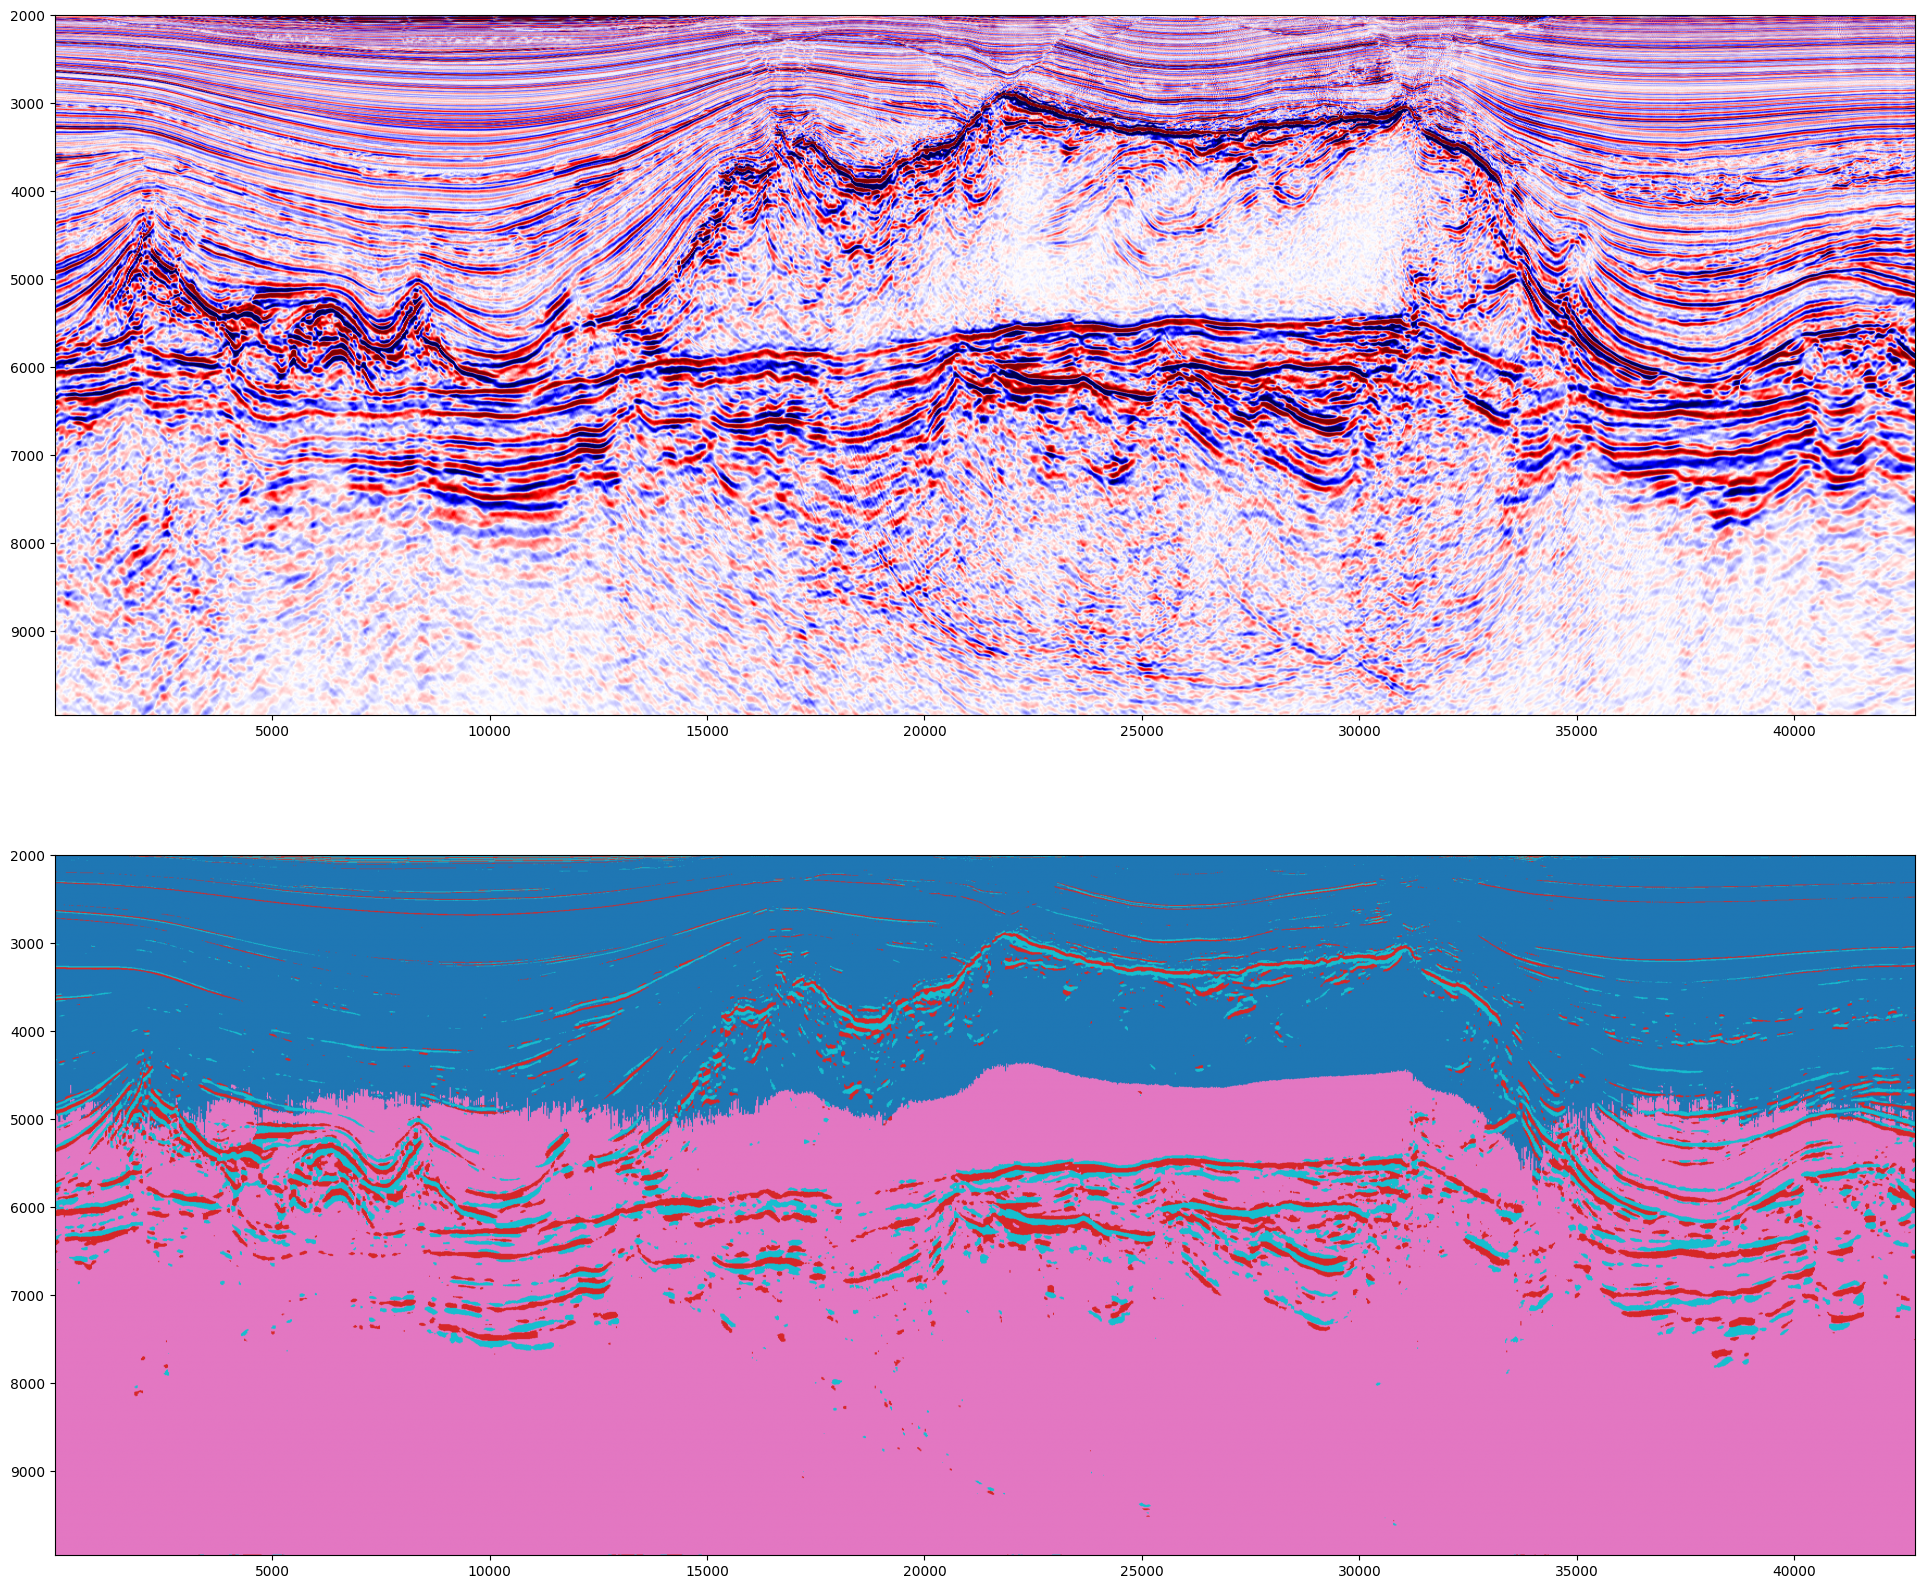

In [12]:
subplot(secao, [secao.X, secao.yhat], colors = ['seismic', 'tab10'], percentils = [(1, 99), (0, 100)])

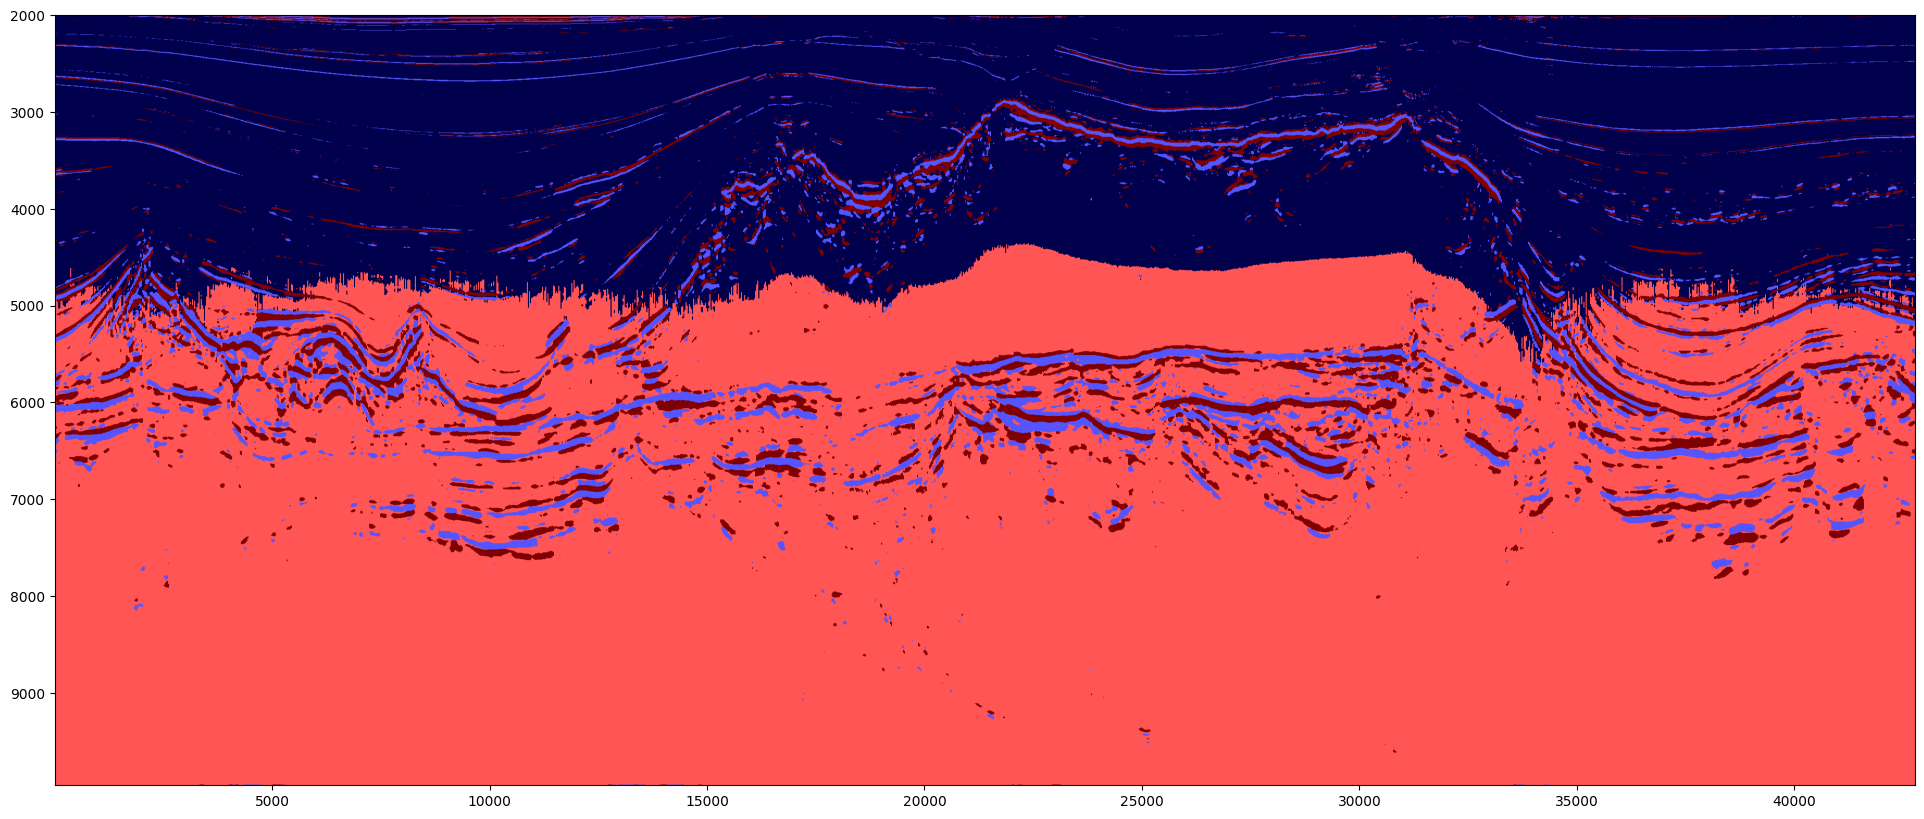

In [13]:
plot(secao, secao.yhat)